# RT2 ASSIGNMENT 2

## Starting from the second assignment of the previouse course, create a jupyter notebook to replace the user interface (the node «A»)

### Try using widgets* to let the user know :
- the position of the robot and all targets that have been set and cancelled in the environment
- the distance of the closest obstacle* (e.g., you can use text boxes, or you can plot the laser scanner info)

In [1]:
#Useful import

import rospy
import actionlib
import actionlib.msg
from geometry_msgs.msg import Point, Pose, Twist, PoseStamped
import assignment_2_2022.msg
from ass2.msg import Info
from nav_msgs.msg import Odometry
import sys
import select
import time
from ass2.srv import target, targetResponse

import jupyros as jr
import ipywidgets as widgets
from ipywidgets import Layout, Box, Label

from turtlesim.msg import Pose
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

import matplotlib.pyplot as plt
import numpy as np

from sensor_msgs.msg import LaserScan

%matplotlib notebook

In [2]:
class Visualiser:
    
    def __init__(self):
        self.fig, self.ax = plt.subplots()
        self.ln, = plt.plot([], [], 'ro')
        self.x_data, self.y_data = [] , []
        
    def plot_init(self):
        self.ax.set_xlim(8, -8)
        self.ax.set_ylim(8, -8)
        return self.ln
    
    def odom_callback(self, msg):
        self.y_data.append(msg.pose.pose.position.y)
        self.x_data.append(msg.pose.pose.position.x)
        
    def update_plot(self, frame):
        self.ln.set_data(self.x_data, self.y_data)
        return self.ln
    
    def add_goal(self, x, y):
        self.ax.plot(x, y, marker='*',markeredgecolor='black')

In [3]:
class VisualiserBar:
    
    def __init__(self):
        self.fig, self.ax = plt.subplots()
        self.res = ['reached','canceled']
        self.n_goals = (0,0)
        self.bar_colors = ['tab:green','tab:red']
        self.bar=self.ax.bar(self.res, self.n_goals, color=self.bar_colors)
        self.ax.set_title('Number of goals reached and canceled')
        
        
    def update(self,r,c):
        self.bar=self.ax.bar( self.res, [r,c], color=self.bar_colors)
        

In [4]:
#Variables Initialization
pose_ = Pose()
twist_= Twist

#Initialize pose object
pose = PoseStamped()

#Initialize counters (Node B)
reach_t = 0
canc_t = 0

#Useful state counter
s = 0


In [5]:
#User Interface settings

#Set the goal coordinate from widget
x_w = widgets.BoundedFloatText(value=0,min= -10, max=10.0,disabled=False)
y_w = widgets.BoundedFloatText(value=0,min= -10, max=10.0,disabled=False)

#Buttons
#send goal
send_btn = widgets.Button(description="Send Goal")
send_btn.style.button_color="lightgreen"

#canc_goal
canc_btn = widgets.Button(description="Canc Goal")
canc_btn.style.button_color="red"

#Labels
obstacle_dist = widgets.Text(value='0.0',description='Collision:', disabled=True)


In [6]:
#Init node
rospy.init_node('node_a')

#Create a new client
client = actionlib.SimpleActionClient('/reaching_goal', assignment_2_2022.msg.PlanningAction)

#Publish (Node A)
pub_info = rospy.Publisher('/bot_info', Info, queue_size=1)

#Publish (Node C)
pub_target = rospy.Publisher('/tgt', Point, queue_size=1)

In [7]:
def send_goal(b):
    
    global client, s
    
    #publish goal to the service and verify 
    x = x_w.value
    y = y_w.value
    
    #nodoc
    tgt(x,y)
    pose.pose.position.x=x
    pose.pose.position.y=y
    
    #create and assign goal
    goal = assignment_2_2022.msg.PlanningGoal(target_pose = pose)
    
    client.send_goal(goal)
    
    s = 1
    
    vis.add_goal(x,y)
    
send_btn.on_click(send_goal)

In [8]:
def canc_goal(b):
    
    global client, canc_t, state
    
    client.cancel_all_goals()
    
    #Take time to process
    time.sleep(1)
    
    #Check the state
    state = client.get_state()
    
    #State 2 corresponds to preempted
    if state == 2:
        canc_t +=1
        vb.update(reach_t,canc_t)
        
canc_btn.on_click(canc_goal)

In [9]:
def clbk_odom(msg):
    
    global client, reach_t, s, pub_info, ax

    x_=msg.pose.pose.position.x
    y_=msg.pose.pose.position.y
    vx_=msg.twist.twist.linear.x
    vy_=msg.twist.twist.linear.y
    
    msg_info = Info()
    
    msg_info.x= x_
    msg_info.y= y_
    msg_info.vel_x= vx_
    msg_info.vel_y= vy_
    
    state = client.get_state()
    if (state == 3 and s == 1):
        reach_t += 1
        vb.update(reach_t,canc_t)
        s = 0
    

    if not rospy.is_shutdown():
        pub_info.publish(msg_info)


In [10]:
#Node C  
def tgt(x,y):
    
    global pub_target

    target_info = Point()
    target_info.x = x
    target_info.y = y
    pub_target.publish(target_info)
    

In [11]:
#Node B
def get_info_goal(req):
    
    global reach_t, canc_t, service
    
    #Response of target.srv
    return targetResponse(reach_t,canc_t)


In [12]:
def clbk_laser(mes):
    
    span = mes.ranges
    closer_obs = sys.float_info.max
    
    for obs in span:
        if obs<closer_obs :
            closer_obs = obs
    
    obstacle_dist.value = str(closer_obs)

In [13]:
#Wait for the server ready
client.wait_for_server()

True

# User Interface


<IPython.core.display.Javascript object>


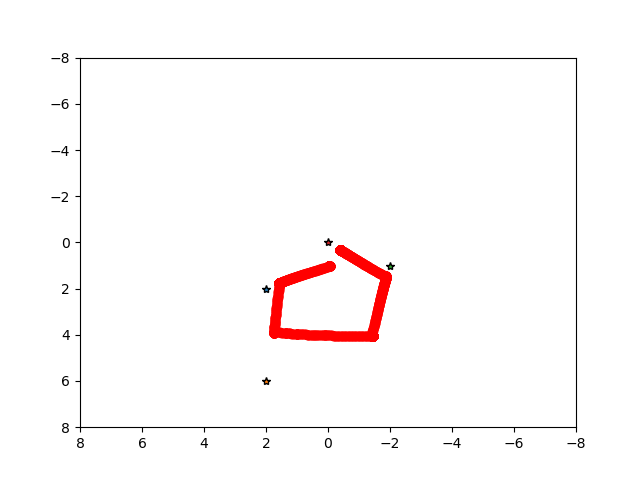

In [14]:
#plot
vis = Visualiser()
sub = rospy.Subscriber('/odom', Odometry, vis.odom_callback)
ani = FuncAnimation(vis.fig, vis.update_plot, init_func=vis.plot_init)
plt.show(block=True)

In [15]:
#Make sub to /odom
sub_odom = rospy.Subscriber('/odom', Odometry, clbk_odom)

#Make sub to /scan
sub_laser = rospy.Subscriber('/scan', LaserScan, clbk_laser) 

#Service definition
service = rospy.Service("goal_info",target, get_info_goal)


In [16]:
#Box
form_item_layout = Layout(
    display='flex_grow',
    flex_flow='row'
)

form_items = [
    Box([Label(value='x position to reach:'), x_w], layout=form_item_layout),
    Box([Label(value='y position to reach:'), y_w], layout=form_item_layout),
    Box([send_btn,canc_btn], layout=form_item_layout),
    Box([obstacle_dist], layout=form_item_layout)
]

form = Box(form_items, layout=Layout(
    display='flex',
    flex_flow='column',
    border='solid 2px',
    align_items='stretch',
    width='50%'
))
form

Box(children=(Box(children=(Label(value='x position to reach:'), BoundedFloatText(value=0.0, max=10.0, min=-10…

<IPython.core.display.Javascript object>


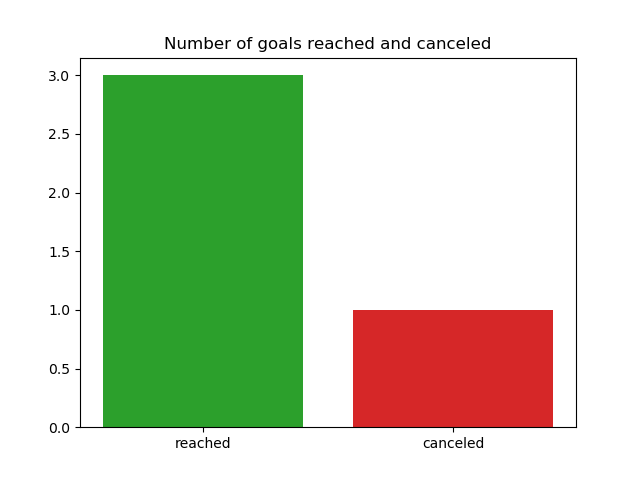

In [17]:
#Histogram
vb= VisualiserBar()